<a href="https://colab.research.google.com/github/sophiawhe/LOX/blob/new_branch/Thermonuclear_Supernova_Classification_Sophia_He/FINAL_GSoC_ML4SCI_L1_L2_Supernova_Clustering_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GSOC ML4Sci: Thermonuclear Supernova Classification via their Nuclear Signatures**

**Name:** Sophia He

**Mentors:** Richard Miller, James Mastandrea, Patrick Peplowski

**Creation Date:** Jun 8, 2021

**Last Updated:** Aug 12, 2021

**Environment:** This iPython Notebook was created and edited in Google Colab. 

**Instructions for Running Notebook:** In Colab, select Runtime -> Run All. Click on Choose Files and select the files `GSOC_DataCube_L1.txt`, `GSOC_DataCube_L2.txt`, `GSOC_Physical_L1.txt`, and `GSOC_Physical_L2.txt` locally. The rest of the notebook should run smoothly from that point on.

In [ ]:
# imports and file uploads (imports in hidden cell below)
from google.colab import files
uploaded = files.upload()

Saving GSOC_DataCube_L1.txt to GSOC_DataCube_L1 (2).txt
Saving GSOC_DataCube_L2.txt to GSOC_DataCube_L2 (2).txt
Saving GSOC_Physical_L1.txt to GSOC_Physical_L1 (2).txt
Saving GSOC_Physical_L2.txt to GSOC_Physical_L2 (2).txt


In [ ]:
#@title 
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as pyo
pyo.init_notebook_mode()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import SCORERS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from numpy import absolute, mean, std
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from warnings import filterwarnings
filterwarnings('ignore')

#About
Using Thermonuclear Supernovae (Type-Ia or SNeIa) simulation data, the aim of this iPython Notebook is to identify machine learning and computational techniques suitable for producing a cluster-predict model that identifies cluster classes based on observable parameters and identifies suitable regression algorithms for prediction in order to ultimately establish classification metrics for Type-Ia supernovae.

#Data

The supernova simulation gamma-ray dataset for L1 and L2 light curves are uploaded as dataframes. The files, with 512 data points each, are identical save for the tau and tau uncertainty parameters for the respective datasets.

In [ ]:
# initialize data frame L1
df_L1 = pd.read_csv('GSOC_DataCube_L1.txt', sep=" ", header=None)
df_L1.columns = ["tau_L1", "tau_uncertainty_L1", "vmax", "vmax_uncertainty", "phi300", "total_mass", "mass_56_Ni", "explosion_energy", "init_SNeIa_dist_flag", "init_56Ni_dist_flag"]

# initialize data frame L2
df_L2 = pd.read_csv('GSOC_DataCube_L2.txt', sep=" ", header=None)
df_L2.columns = ["tau_L2", "tau_uncertainty_L2", "vmax", "vmax_uncertainty", "phi300", "total_mass", "mass_56_Ni", "explosion_energy", "init_SNeIa_dist_flag", "init_56Ni_dist_flag"]

In [ ]:
# view part of data frame
df_L1.head()

tau_L1  tau_uncertainty_L1  ...  init_SNeIa_dist_flag  init_56Ni_dist_flag
0  1.333810            0.081978  ...                  hed8                 hed8
1  1.853153            0.183197  ...                  hed8                  mwd
2  1.682448            0.154169  ...                  hed8                 N100
3  1.123935            0.108683  ...                  hed8                 w7dt
4  1.295746            0.079293  ...                  hed8                 hed8

[5 rows x 10 columns]

In [ ]:
# view part of data frame
df_L2.head()

tau_L2  tau_uncertainty_L2  ...  init_SNeIa_dist_flag  init_56Ni_dist_flag
0  1.940628            0.179354  ...                  hed8                 hed8
1  2.071999            0.210287  ...                  hed8                  mwd
2  2.007982            0.198804  ...                  hed8                 N100
3  1.661535            0.189436  ...                  hed8                 w7dt
4  1.907672            0.178607  ...                  hed8                 hed8

[5 rows x 10 columns]

###Combining L1 and L2 data
The L1 and L2 gamma ray observable data are combined — `tau_L1`,`tau_L2`, `vmax`, and `phi300`. This df will be preprocessed and used for clustering.

In [ ]:
# L1 observable data
df_observable_L1 = df_L1[["tau_L1"]]
# L2 observable data
df_observable_L2 = df_L2[["tau_L2", "vmax", "phi300"]]
# combined L1 and L2 observable data
df_observable = pd.concat([df_observable_L1, df_observable_L2], axis=1, join='inner')
df_observable.head()

tau_L1    tau_L2      vmax    phi300
0  1.333810  1.940628  0.013531  0.000003
1  1.853153  2.071999  0.012423  0.000003
2  1.682448  2.007982  0.012744  0.000003
3  1.123935  1.661535  0.009935  0.000003
4  1.295746  1.907672  0.013343  0.000003

###Understanding Uncertainty Proportions
The uncertainties for L1 tau, L2 tau, and vmax are explored. All uncertainties fall within hundredths of the data they correspond to.

In [ ]:
# average of (tau uncertainty L1 / tau L1)
L1_tau_prop = df_L1['tau_uncertainty_L1']/df_L1['tau_L1']
print("mean (L1 tau uncertainty)/(L1 tau) ratio:", L1_tau_prop.mean())

mean (L1 tau uncertainty)/(L1 tau) ratio: 0.05915889680484558


In [ ]:
# average of (tau uncertainty L2 / tau L2)
L2_tau_prop = df_L2['tau_uncertainty_L2']/df_L2['tau_L2']
print("mean (L2 tau uncertainty)/(L2 tau) ratio:", L2_tau_prop.mean())

mean (L2 tau uncertainty)/(L2 tau) ratio: 0.07854475790590866


In [ ]:
# average of (vmax uncertainty / vmax)
df_vmax_prop = df_L1['vmax_uncertainty']/df_L1['vmax']
print("mean (vmax uncertainty)/(vmax) ratio:", df_vmax_prop.mean())

mean (vmax uncertainty)/(vmax) ratio: 0.03992691569603405


### Defining Plotting Functions
The plotting functions will be used to plot cluster data for L1 and L2 observable parameters.

In [ ]:
def plot_clusters_2d_L1(clusters, labels, main_title):
  '''
  Plots three separate 2-D scatterplot projections of the clustering data for L1 data
  
  Inputs: 
  clusters - data frame with cluster information
  labels - cluster information data frame (single column with same amount of rows as clusters df)
  main_title - string for the title of the graph
  '''
  fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(22,6))
  sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,2], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax1)
  sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,3], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax2)
  sns.scatterplot(clusters.iloc[:,2],clusters.iloc[:,3], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax3)

  fig.suptitle(main_title, fontsize=15) 
  plt.show()

def plot_clusters_2d_L2(clusters, labels, main_title):
  '''
  Plots three separate 2-D scatterplot projections of the clustering data for L2 data

  Inputs: 
  clusters - data frame with cluster information
  labels - cluster information data frame (single column with same amount of rows as clusters df)
  main_title - string for the title of the graph
  '''
  fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(22,6))
  sns.scatterplot(clusters.iloc[:,1],clusters.iloc[:,2], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax1)
  sns.scatterplot(clusters.iloc[:,1],clusters.iloc[:,3], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax2)
  sns.scatterplot(clusters.iloc[:,2],clusters.iloc[:,3], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax3)

  fig.suptitle(main_title, fontsize=15) 
  plt.show()

##Plotting Flag Data
The observable L2 data is plotted in 2D planes based on the physical non-numerical flag parameters init_SNeIa_dist_flag and init_56Ni_dist_flag respectively. This is to observe for any initial patterns in the data based on physical categorical parameters.

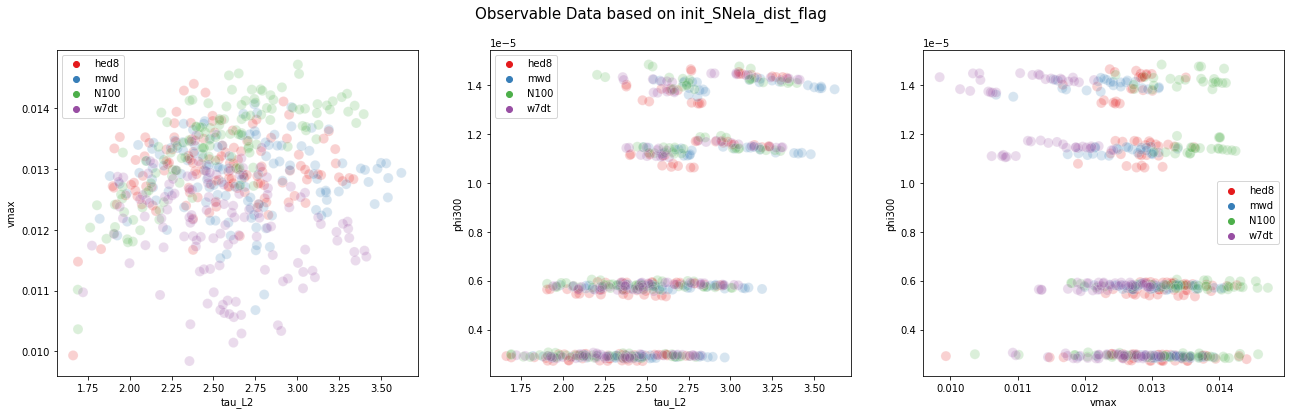

In [ ]:
  # copy L2 data frame
  df = df_L2.copy()

  # plot observable data based on init_SneIa_dist_flag
  fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(22,6))
  sns.scatterplot(df.iloc[:,0],df.iloc[:,2], hue=df.loc[:,'init_SNeIa_dist_flag'].values, palette='Set1', s=100, alpha=0.2, ax=ax1)
  sns.scatterplot(df.iloc[:,0],df.iloc[:,4], hue=df.loc[:,'init_SNeIa_dist_flag'].values, palette='Set1', s=100, alpha=0.2, ax=ax2)
  sns.scatterplot(df.iloc[:,2],df.iloc[:,4], hue=df.loc[:,'init_SNeIa_dist_flag'].values, palette='Set1', s=100, alpha=0.2, ax=ax3)

  fig.suptitle("Observable Data based on init_SNeIa_dist_flag", fontsize=15) 
  plt.show()

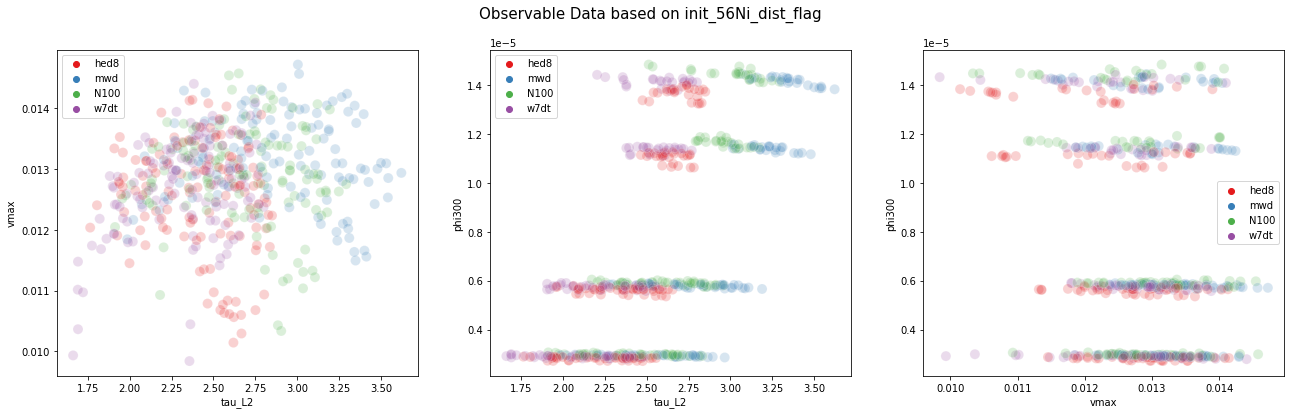

In [ ]:
  # plot observable data based on init_56Ni_dist_flag
  fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(22,6))
  sns.scatterplot(df.iloc[:,0],df.iloc[:,2], hue=df.loc[:,'init_56Ni_dist_flag'].values, palette='Set1', s=100, alpha=0.2, ax=ax1)
  sns.scatterplot(df.iloc[:,0],df.iloc[:,4], hue=df.loc[:,'init_56Ni_dist_flag'].values, palette='Set1', s=100, alpha=0.2, ax=ax2)
  sns.scatterplot(df.iloc[:,2],df.iloc[:,4], hue=df.loc[:,'init_56Ni_dist_flag'].values, palette='Set1', s=100, alpha=0.2, ax=ax3)

  fig.suptitle("Observable Data based on init_56Ni_dist_flag", fontsize=15) 
  plt.show()

# Preprocessing: Standardization

The features are standardized by removing the mean and scaling to unit variance. For the `StandardScaler()` function the standard score of a sample x is calculated as:

`z = (x - u) / s`

where u is the mean of the training samples, and s is the standard deviation of the training samples.

In [ ]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(df_observable)
X_scale = scaler.transform(df_observable)
# df_scale is the newly scaled data
df_scale = pd.DataFrame(X_scale, columns=df_observable.columns)
df_scale.head()

tau_L1    tau_L2      vmax    phi300
0 -1.824054 -1.627265  0.845068 -1.105597
1 -0.926036 -1.290953 -0.461417 -1.046349
2 -1.221209 -1.454840 -0.082589 -1.043236
3 -2.186957 -2.341748 -3.395666 -1.060238
4 -1.889872 -1.711635  0.623577 -1.103794

##PCA

The explained variance percentage for Principle Component Analysis (PCA) vs. the number of principle component features was plotted to select for the number of features explaining 70% of the variance or greater. Ultimately a `n_components` of 2 was chosen. 1 feature would have only explained ~61% of the variance while 2 features gave a percent explained variance of ~91%.

variance array [ 61.2  90.8  99.7 100. ]


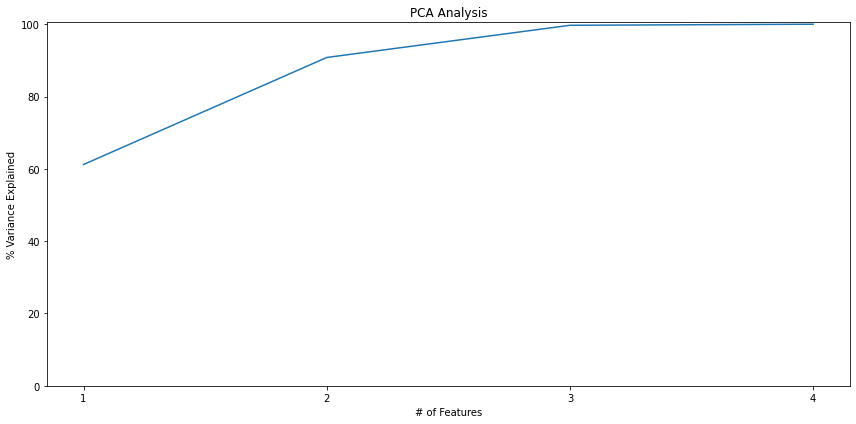

In [ ]:
#PCA
def perform_pca_analysis(df):
  '''
  performs PCA on varying number of features and plots the number of features
  vs. the % variance explained for the PCA.

  inputs:
  df - dataframe to perform PCA analysis on
  '''
  # n_components = num features in the dataset
  pca = PCA(n_components=len(df.columns))
  pca.fit(df)
  variance = pca.explained_variance_ratio_
  var = np.cumsum(np.round(variance, 3)*100)
  plt.figure(figsize=(12,6))
  plt.ylabel('% Variance Explained')
  plt.xlabel('# of Features')
  plt.title('PCA Analysis')
  plt.ylim(0,100.5)
  plt.locator_params(axis="both", integer=True, tight=True)
  plt.tight_layout()
  plt.plot([1,2,3,4], var)
  print("variance array", var)

perform_pca_analysis(df_scale)

In [ ]:
#perform pca transformation on scaled dataset of observable parameters
pca = PCA(n_components=2)
pca_scale = pca.fit_transform(df_scale)
pca_df_scale = pd.DataFrame(pca_scale, columns=['pc1','pc2'])
print(pca.explained_variance_ratio_)

[0.61163464 0.29616582]


##Contribution of Original Variables to Principle Components
PCA loadings are the coefficients of the linear combination of the original variables from which the principal components (PCs) are constructed. Each element represents a loading, the weight/how much each original variable contributes to the corresponding principal component.

The goal of the PCA is to come up with optimal weights for capturing as much information in the original variables as possible, based on the correlations among those variables. The focus is on the magnitude of the contribution regardless of sign. 

In [ ]:
# loadings dataframe
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_scale.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

PC1       PC2
variable                    
tau_L1    0.607643 -0.176529
tau_L2    0.627935 -0.080203
vmax      0.063523 -0.875642
phi300    0.482112  0.442330

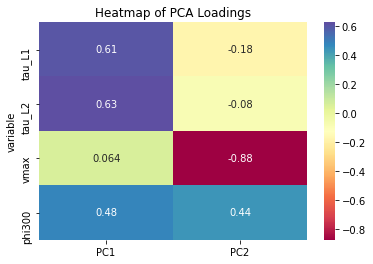

In [ ]:
# loadings dataframe as a heat map
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.title("Heatmap of PCA Loadings")
plt.show()

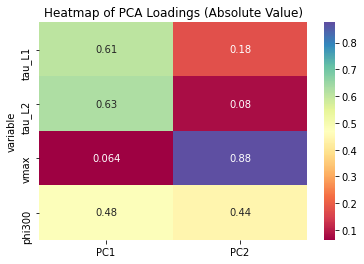

In [ ]:
# loadings dataframe as a magnitude heat map
ax = sns.heatmap(loadings_df.abs(), annot=True, cmap='Spectral')
plt.title("Heatmap of PCA Loadings (Absolute Value)")
plt.show()

#Clustering

##Selected Clustering Algorithms
- K-Means
- Hierarchical Agglomerative
- Mean-Shift
- DBSCAN
- Gaussian Mixture Model




# Clustering With Observable Parameters From L1 and L2 Datasets
Focusing on the observable parameters, clustering is performed on the scaled, PCA-transformed version of the combined L1 and L2 observable parameter dataset.

##Clustering: K-Means

###KMeans Optimization: Elbow Method
We optimize for the number of clusters by plotting the inertia per number of clusters for a range of clusters, using the elbow method to select for the number of clusters where the slope drastically decreases ("the elbow"). The inertia is the within-clusters-sum-of-squares criterion, recognized as a measure of how internally coherent clusters are.

Text(0, 0.5, 'Inertia')

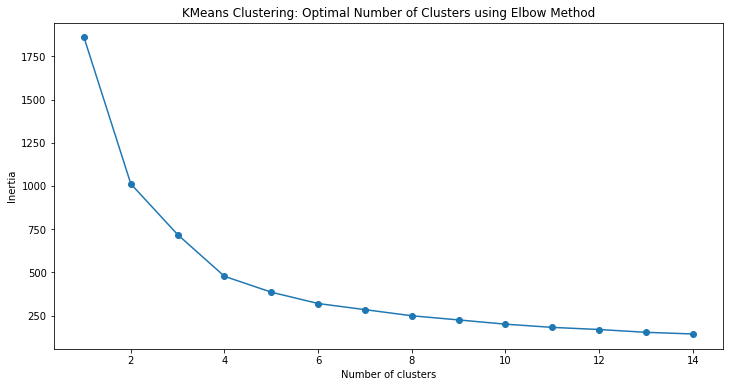

In [ ]:
# initialize array for inertia
sse = []
# run kmeans and obtain inertia, appending to array
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(pca_df_scale)
    sse.append([k, km.inertia_])

# plot results
results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('KMeans Clustering: Optimal Number of Clusters using Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

###KMeans Optimization: Silhouette Score
The Silhouette Coefficient is calculated using the mean intra-cluster distance (mean distance to the other instances in the same cluster) (a) and the mean nearest-cluster distance (mean distance to the instances of the next closest cluster) (b) for each sample. The Silhouette Coefficient for a sample is `(b - a) / max(a, b)`.

The coefficient varies between -1 and 1. A value close to 1 implies that the point is close to its cluster is a part of the right cluster. Whereas, a value close to -1 means that the value is assigned to the wrong cluster.

A `num_clusters` of 2 and a `num_clusters` of 4 have the relatively highest silhouette scores. A `num_clusters` of 4 is selected in this case, corresponding to one of the highest silhouette scores and the "elbow" using the elbow method, and the resulting k-means clustering pattern is plotted below.

Text(0, 0.5, 'Silhouette Score')

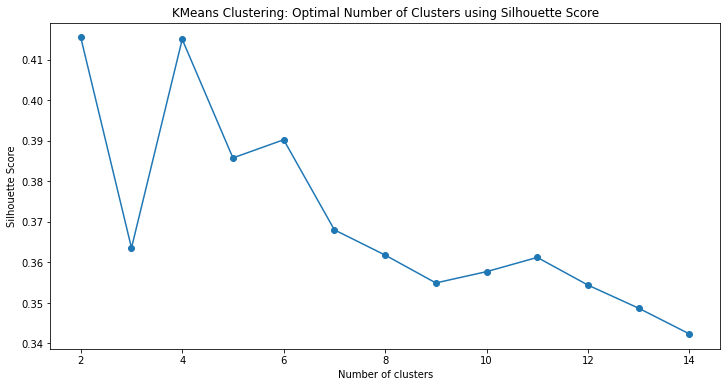

In [ ]:
# initialize array for silhouette scores
silhouette = []
# run kmeans for increasing number of clusters and obtain silhouette score
k_list = range(2, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(pca_df_scale)
    silhouette.append([k, silhouette_score(pca_df_scale, km.labels_, metric='euclidean')])

# plot results - silhouette score vs. number of clusters
results_scale = pd.DataFrame({'Cluster': range(2,15), 'Silhouette': silhouette})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(silhouette)[0], pd.DataFrame(silhouette)[1], marker='o')
plt.title('KMeans Clustering: Optimal Number of Clusters using Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

In [ ]:
# set number of clusters
num_clusters = 4
# run kmeans algorithm
k_means = KMeans(n_clusters=num_clusters, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(pca_df_scale)
print('KMeans Silhouette Score: {}'.format(silhouette_score(pca_df_scale, k_means.labels_, metric='euclidean')))
labels_kmeans = k_means.labels_
clusters_kmeans = pd.concat([df_observable, pd.DataFrame({'clusters':labels_kmeans})], axis=1)

KMeans Silhouette Score: 0.4150473727488921


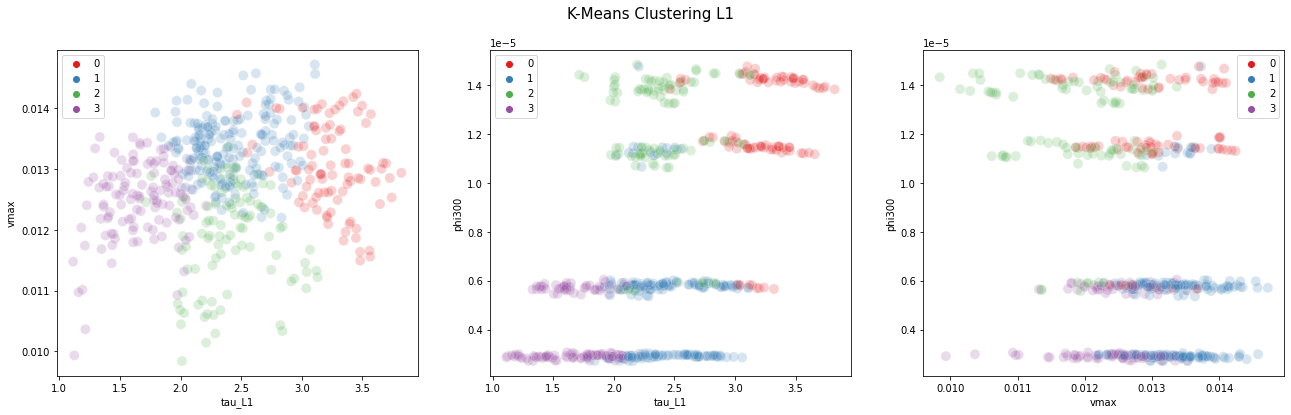

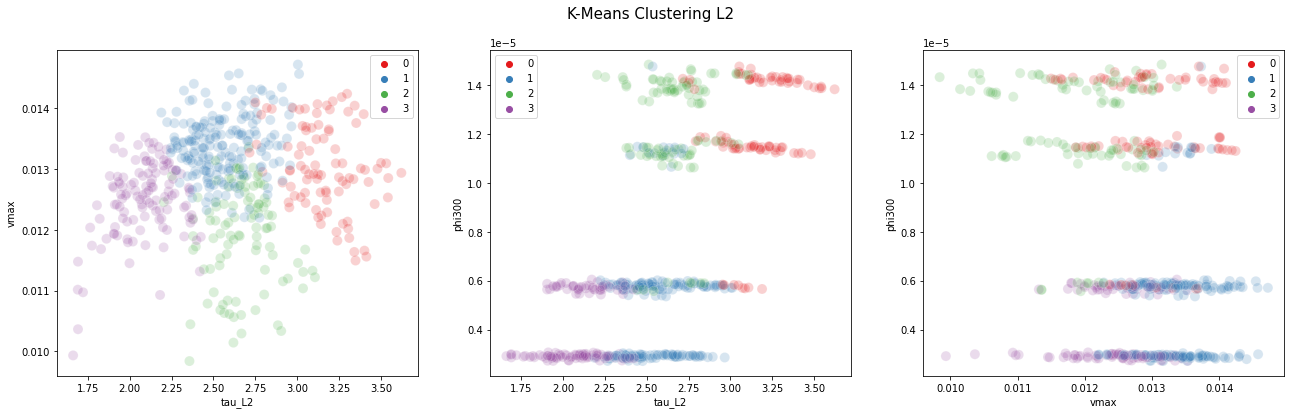

In [ ]:
plot_clusters_2d_L1(clusters_kmeans, labels_kmeans, "K-Means Clustering L1")
plot_clusters_2d_L2(clusters_kmeans, labels_kmeans, "K-Means Clustering L2")

##Clustering: Agglomerative Hierarchical Clustering

The agglomerative hierarchical clustering method creates a bottom up "tree" (a dendrogram) based upon the dissimilarities between objects (euclidean distance. Data points agglomerate, forming clusters until one single cluster is formed (the whole dataset). The dendrogram represents a hierarchy of partitions, allowing a partition to be chosen by truncating the "tree" at a given level, which will in turn be how many clusters there are. The level to truncate the "tree" at depends upon either user-defined constraints (the user knows how many classes are to be obtained) or more objective criteria. The silhouette score method is used again in this case.

The number of clusters vs. silhouette score is plotted, and the `num_clusters` corresponding to the highest silhouette score is 4. The agglomerative clustering algorithm is then applied to the scaled PCA-transformed gamma-ray light curve dataset, and the resulting clusters are plotted below.



Text(0, 0.5, 'Silhouette Score')

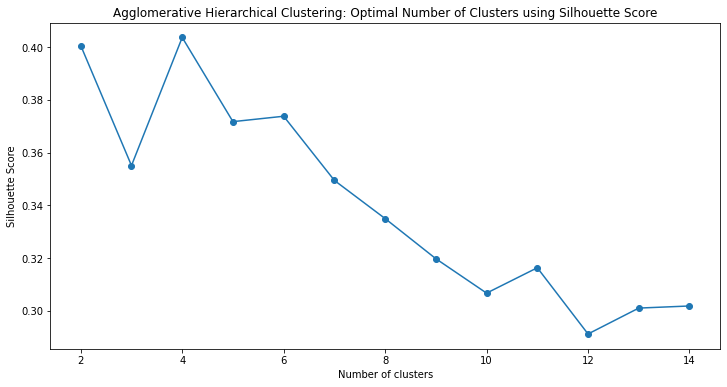

In [ ]:
# initialize array for silhouette score
silhouette = []
k_list = range(2, 15)
# run agg clustering to obtain silhouette scores
for k in k_list:
    agg = AgglomerativeClustering(n_clusters=k)
    agg.fit(pca_df_scale)
    silhouette.append([k, silhouette_score(pca_df_scale, agg.labels_, metric='euclidean')])

# plot silhouette score vs num clusters
results_scale = pd.DataFrame({'Cluster': range(2,15), 'Silhouette': silhouette})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(silhouette)[0], pd.DataFrame(silhouette)[1], marker='o')
plt.title('Agglomerative Hierarchical Clustering: Optimal Number of Clusters using Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

In [ ]:
# perform agglomerative clustering
X = pca_df_scale
agg_clustering = AgglomerativeClustering(n_clusters=4).fit(X)
labels_agg = agg_clustering.labels_
clusters_agg = pd.concat([df_observable, pd.DataFrame({'clusters':labels_agg})], axis=1)

print('Agglomerative Clustering Silhouette Score: {}'.format(silhouette_score(pca_df_scale, labels_agg, metric='euclidean')))

Agglomerative Clustering Silhouette Score: 0.40365222565736625


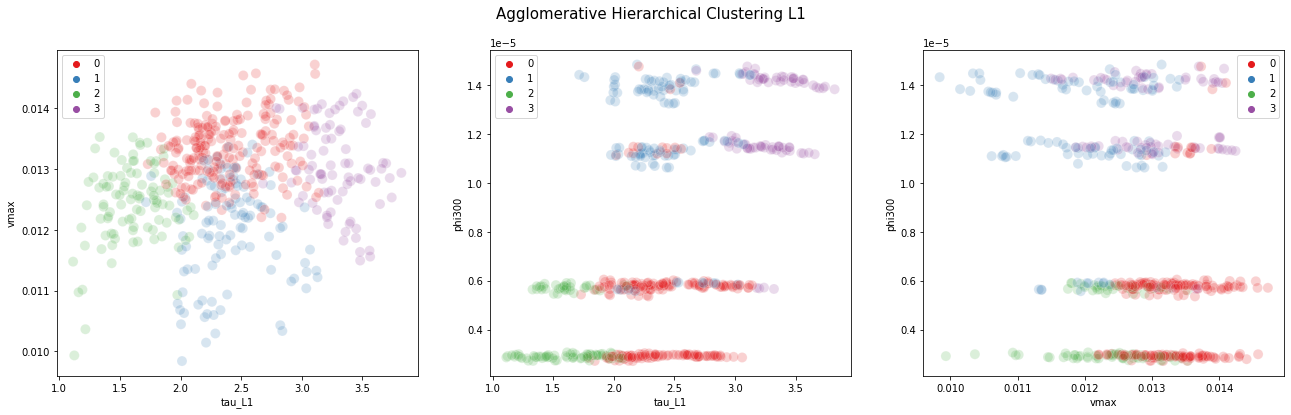

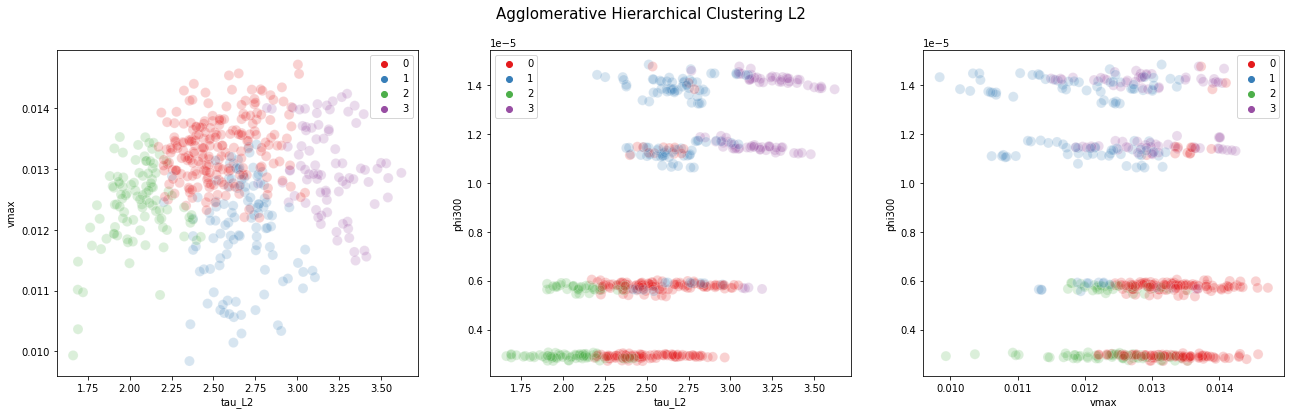

In [ ]:
plot_clusters_2d_L1(clusters_agg, labels_agg, "Agglomerative Hierarchical Clustering L1")
plot_clusters_2d_L2(clusters_agg, labels_agg, "Agglomerative Hierarchical Clustering L2")

##Clustering: Mean-Shift Clustering

Mean-shift clustering does not require specifying number of clusters in advance and is a centroid based algorithm. It uses a gaussian kernel (weighting function) that has a `bandwidth` parameter, and places this kernel on each point in the data set, then generates a probability surface example density function when all individual kernels are summed. This probability surface can be visualized as a contour plot. The mean shift algorithm iteratively shifts each point "uphill" untill it reaches a peak.

Mean shift clustering aims to discover “blobs” in a smooth density of samples. It updates candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

**Determining Kernel Bandwidth**

The `estimate_bandwidth` function uses nearest neighbors to estimate the bandwidth to use with the mean-shift algorithm. The quantile parameter, which should be a float between [0,1], determines the n_neighbors parameter for nearest neighbors. 

The `estimate_bandwidth` function takes in a quantile parameter as an input. Tuning for the quantile parameter, silhouette score is used; the quantile vs. silhouette score is plotted. From this plot, a quantile of 0.15 is used to determine a bandwidth for the mean-shift algorithm (choosing based on highest silhouette score). The resulting clusters are plotted and shown below.

Text(0, 0.5, 'Silhouette Score')

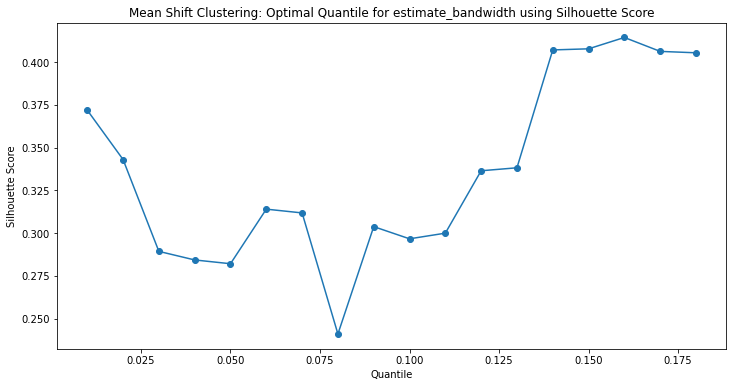

In [ ]:
X = pca_df_scale

# intialize silhouette array
silhouette = []
k_list = np.arange(0.01, 0.19, 0.01)
for k in k_list:
    band = estimate_bandwidth(X, quantile=k)
    ms = MeanShift(bandwidth=band, bin_seeding=True)
    ms.fit(X)
    silhouette.append([k, silhouette_score(pca_df_scale, ms.labels_, metric='euclidean')])

# plot silhouette score vs. quantile 
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(silhouette)[0], pd.DataFrame(silhouette)[1], marker='o')
plt.title('Mean Shift Clustering: Optimal Quantile for estimate_bandwidth using Silhouette Score')
plt.xlabel('Quantile')
plt.ylabel('Silhouette Score')

In [ ]:
# estimate bandwidth with quantile set to 0.15
bandwidth = estimate_bandwidth(X, quantile=0.15)
print('Bandwidth:', bandwidth)
# run ms with estimated bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels_ms = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels_ms)
n_clusters_ = len(labels_unique)

# df with ms clusters results
clusters_ms = pd.concat([df_observable, pd.DataFrame({'clusters':labels_ms})], axis=1)

# print cluster information
print("Number of estimated clusters : %d" % n_clusters_)
print('Mean Shift Clustering Silhouette Score: {}'.format(silhouette_score(pca_df_scale, labels_ms, metric='euclidean')))

Bandwidth: 1.1371267332651374
Number of estimated clusters : 2
Mean Shift Clustering Silhouette Score: 0.407814022421806


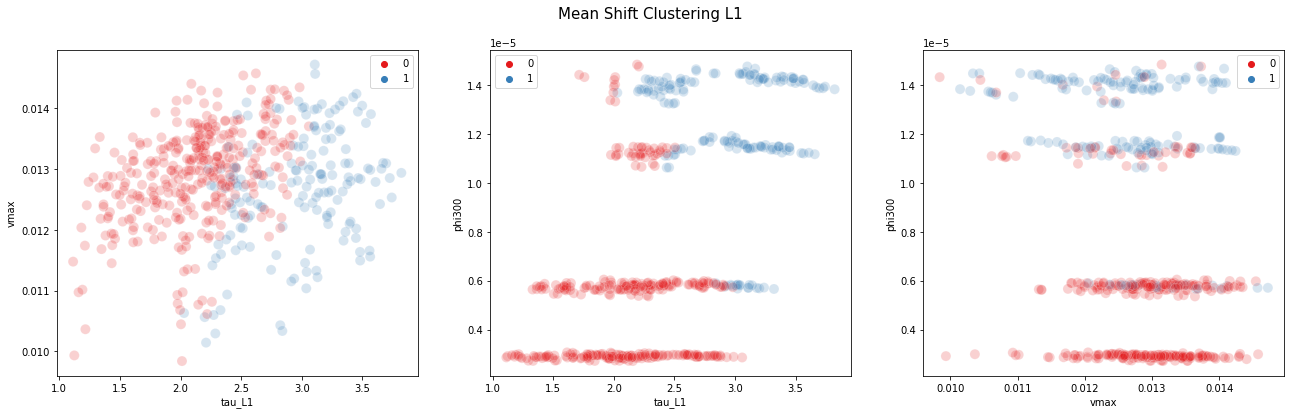

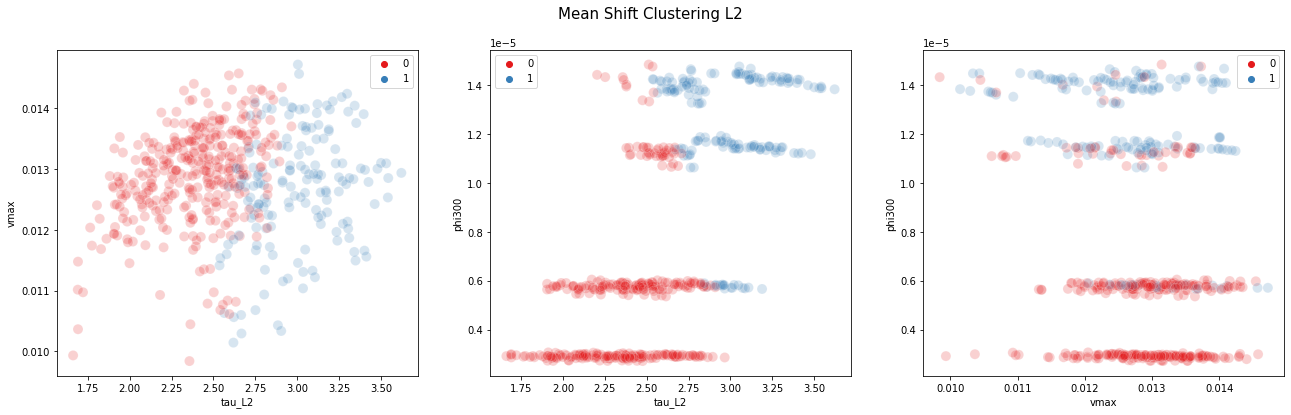

In [ ]:
plot_clusters_2d_L1(clusters_ms, labels_ms, "Mean Shift Clustering L1")
plot_clusters_2d_L2(clusters_ms, labels_ms, "Mean Shift Clustering L2")

##Clustering: Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

The DBSCAN algorithm groups ‘densely grouped’ data points into a single cluster and can identify clusters in large spatial datasets by looking at the local density of the data points. The algorithm is robust to outliers and does not require the number of clusters to be specified beforehand. A starting point is selected at random at its neighborhood area is determined using radius eps. If there are at least minPts number of points in the neighborhood, the point is marked as core point and a cluster formation starts. If not, the point is marked as noise. Once a cluster formation starts (for example, cluster A), all the points within the neighborhood of initial point become a part of cluster A. If these new points are also core points, the points that are in the neighborhood of them are also added to cluster A.

DBSCAN requires two parameters: 

- *Epsilon*: the radius of the circle to be created around each data point to check the density 
- *minPoints*: the minimum number of data points required inside that circle for that data point to be classified as a Core point

###Tuning for epsilon and minPoints 

minPoints (also known as minSamples) is selected based on the domain knowledge. It is suggested that minPoints = 2*(number of dimensions in the data set)

We find a suitable value for epsilon by calculating the distance to the nearest n points for each point, sorting and plotting the results. We then find where the change is most pronounced and select that as epsilon.

1. For every point in dataset, compute the distance of its minPts nearest neighbor
2. Sort the distances in the increasing order.
3. Plot the chart of distances on Y-axis versus the index of the datapoints on X-axis.
4. Observe the sudden increase ('elbow' or 'knee') in the plot. Select the distance value that corresponds to the 'elbow' as optimal epsilon

minPoints is set at 4, using the formula (2*number of dimensions), and using the elbow method in the nearest neighbors plot, epsilon is selected to be 0.4, and the resulting clusters are shown below.

Note: the resulting clusters are not distinct.


Text(0.5, 1.0, 'Nearest Neighbors Distances vs. Datapoints Indices')

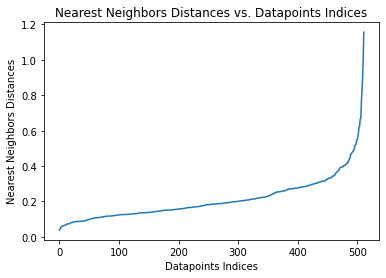

In [ ]:
X = pca_df_scale
# run nearest neighbors on data with n_neighbors=minPoints
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(X)
# plot nearest neighbors distances vs. indices of the datapoints
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,3]
plt.plot(distances)
plt.ylabel('Nearest Neighbors Distances')
plt.xlabel('Datapoints Indices')
plt.title('Nearest Neighbors Distances vs. Datapoints Indices')

In [ ]:

# Compute DBSCAN
dbscan = DBSCAN(eps=0.4, min_samples=4).fit(X)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels_dbscan = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_ = list(labels_dbscan).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# df of observable data with cluster column appended
clusters_dbscan = pd.concat([df_observable, pd.DataFrame({'clusters':labels_dbscan})], axis=1)

print('DBSCAN Clustering Silhouette Score: {}'.format(silhouette_score(pca_df_scale, labels_dbscan, metric='euclidean')))

Estimated number of clusters: 3
Estimated number of noise points: 15
DBSCAN Clustering Silhouette Score: 0.16640674738502798


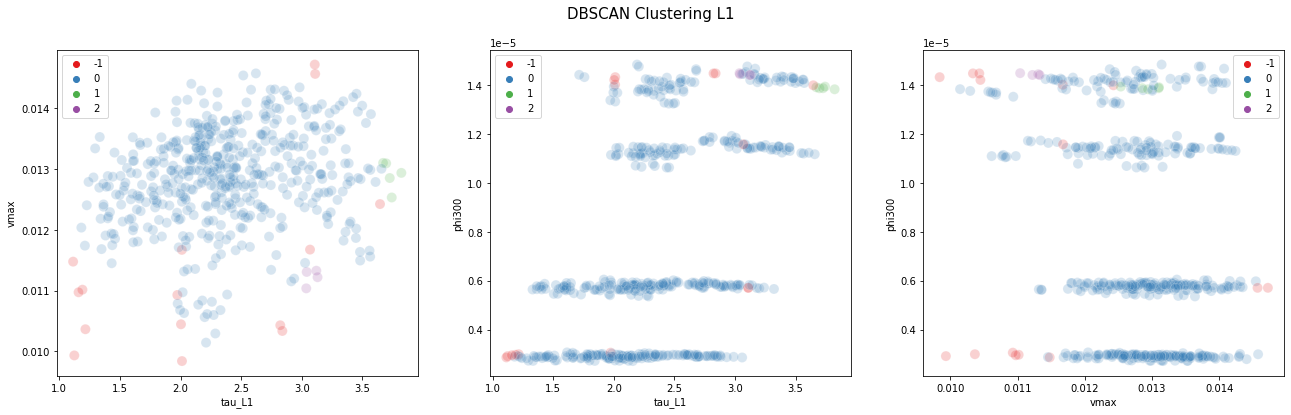

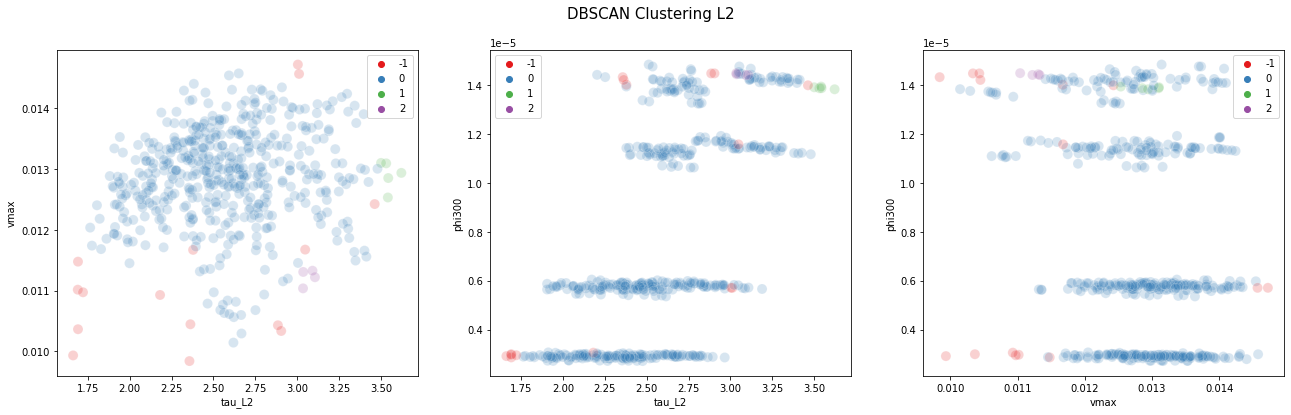

In [ ]:
plot_clusters_2d_L1(clusters_dbscan, labels_dbscan, "DBSCAN Clustering L1")
plot_clusters_2d_L2(clusters_dbscan, labels_dbscan, "DBSCAN Clustering L2")

##Clustering: Expectation–Maximization (EM) Clustering using Gaussian Mixture Models (GMM)

The EM algorithm using GMM selects the number of clusters (like K-Means does) and randomly initializing the Gaussian distribution parameters for each cluster. Given the Gaussian distributions for each cluster, the algorithm computes the probability that each data point belongs to a particular cluster. Based on these probabilities, it then computes a new set of parameters for the Gaussian distributions such that the probabilities of data points within the clusters are maximized. This is repeated iteratively until convergence.

Akaike information criterion (AIC) or the Bayesian information criterion (BIC) are used as analytical criterion to adjust model likelihoods for overfitting; the optimal number of clusters is the value that minimizes the AIC or BIC. In this case, both are considered.



## AIC/BIC and Silhouette Score
- AIC and BIC are both penalized-likelihood criteria
- The AIC or BIC for a model is usually written in the form [-2logL + kp], where L is the likelihood function, p is the number of parameters in the model, n is the number of data points, and k is 2 for AIC and log(n) for BIC.
- AIC is an estimate of a constant plus the relative distance between the unknown true likelihood function of the data and the fitted likelihood function of the model; a lower AIC means a model is considered to be closer to the truth. 
- BIC is an estimate of a function of the posterior probability of a model being true, under a certain Bayesian setup; a lower BIC means that a model is considered to be more likely to be the true model.

In addition to AIC and BIC, silhouette score is used as a tuning parameter, plotting Silhouette Score vs. Number of Clusters.

Selecting for a low AIC and BIC and a high silhouette score, a cluster number of 4 is determined for the Gaussian Mixture clustering algorithm and the cluster results are plotted below.

No handles with labels found to put in legend.


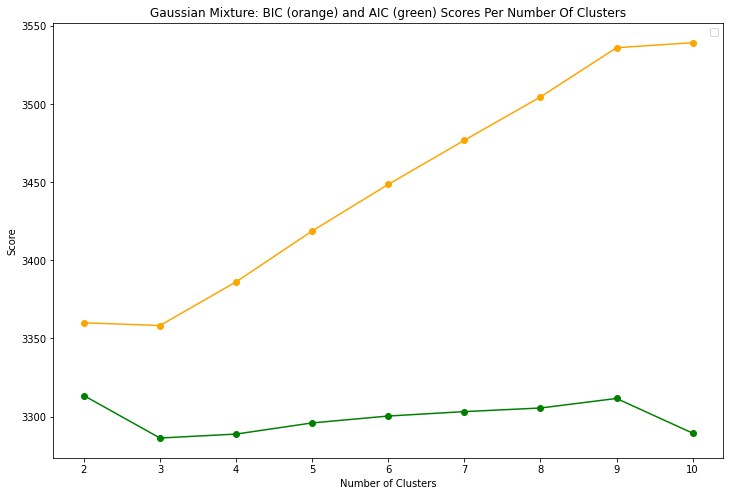

In [ ]:
X = pca_df_scale

# set up a range of cluster numbers to try
n_range = range(2,11)

# create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, random_state=123, n_init=10)
    gm.fit(X)
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(X))
    aic_score.append(gm.aic(X))
    
# plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('Gaussian Mixture: BIC (orange) and AIC (green) Scores Per Number Of Clusters')
ax.legend()

Text(0, 0.5, 'Silhouette Score')

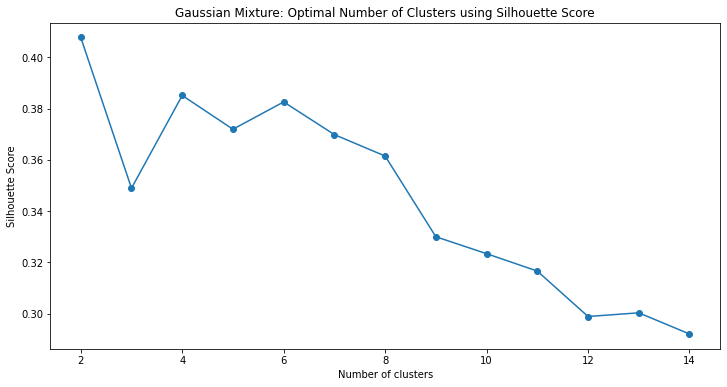

In [ ]:
# initialize array to plot silhouette score corresponding to n_clusters
silhouette = []
k_list = range(2, 15)
for k in k_list:
  total_score = 0
  for i in range(20):
    # create GMM for k components (clusters)
    gm = GaussianMixture(n_components=k, random_state=123, n_init=10)
    gm.fit(X)
    total_score += silhouette_score(pca_df_scale, gm.predict(X), metric='euclidean')
  # append to silhouette array
  silhouette.append([k, total_score/20])

# plot silhouette vs. number of clusters
results_scale = pd.DataFrame({'Cluster': range(2,15), 'Silhouette': silhouette})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(silhouette)[0], pd.DataFrame(silhouette)[1], marker='o')
plt.title('Gaussian Mixture: Optimal Number of Clusters using Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

In [ ]:
#  set number of clusters = 4
n = 4
# GMM
gm = GaussianMixture(n_components=n, random_state=123, n_init=10)
gm.fit(X)
labels_gm = gm.predict(X)
# create resulting clusters df for GMM
clusters_gm = pd.concat([df_observable, pd.DataFrame({'clusters':labels_gm})], axis=1)
print('Gaussian Mixture Model Clustering Silhouette Score: {}'.format(silhouette_score(pca_df_scale, labels_gm, metric='euclidean')))

Gaussian Mixture Model Clustering Silhouette Score: 0.38510828410963716


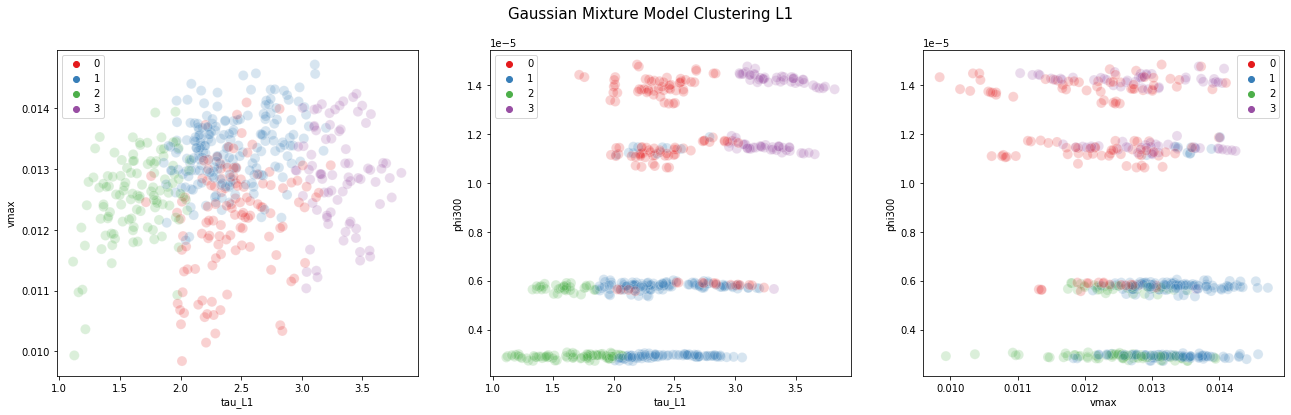

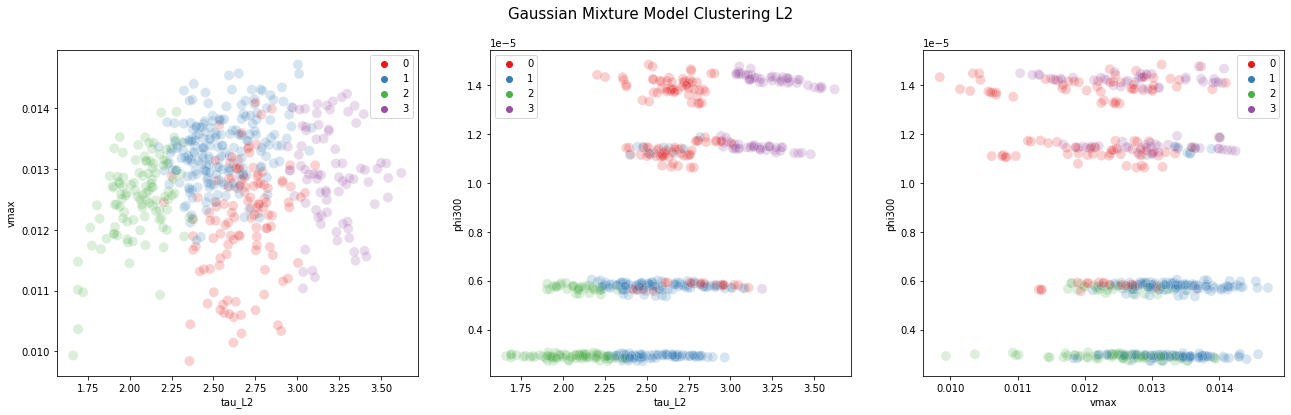

In [ ]:
plot_clusters_2d_L1(clusters_gm, labels_gm, "Gaussian Mixture Model Clustering L1")
plot_clusters_2d_L2(clusters_gm, labels_gm, "Gaussian Mixture Model Clustering L2")

#Regression
We incorporate a prediction model based on cluster data results, using multioutput regression for prediction.

Regression refers to a predictive modeling problem that involves predicting a numerical value - multioutput regression is predicting two or more numeric outputs.

**Selected ML Regression Algorithms**
- *Linear Regression*: model assumes a linear relationship between the input variables and the output variables
- *K Nearest Neighbors Regression*: approximates the association between independent variables and the continuous outcome by averaging the observations in the same neighbourhood
- *Decision Tree Regression*: builds regression models in the form of a tree structure; breaks down a dataset into smaller and smaller subsets while an associated decision tree is incrementally developed
- *Random Forest Regression*: many decision trees are run in parallel during model training

##Regression with K-Means Clustered Data
Regression and testing is performed with KMeans cluster results.

###Regression with K-Means Clustered Data: Data Preparation
We prepare a dataframe of combined L1 and L2 gamma ray supernova simulation data. The K-Means cluster category (numerical labels) data is appended to this dataframe. The non-numerical categorical data is split into columns corresponding to each category using the get_dummies function; this transforms the data into numerical data, as each column is marked with a 1 for true (corresponds to category) and 0 for false (does not correspond to category).

Following, we define features (observable parameters) and targets (physical parameters) for prediction.


In [ ]:
def prepare_cluster_df(cluster_data):
  '''
  prepares a complete dataframe to be used for regression 
  applies get_dummies to categorical, non-numerical data
  
  inputs:
  cluster_data - a single column of cluster result data
  returns:
  df_view - a dataframe with both physical and observable parameters, with
            cluster data results appended
  '''
  df_view = df_L2.copy()
  df_L1_concat = df_L1[["tau_L1", "tau_uncertainty_L1"]]
  df_view = pd.concat([df_L1_concat, df_view], axis=1, join='inner')
  df_view['cluster'] = cluster_data
  # get dummies - (results similar to one hot encoding)
  df_view = pd.get_dummies(df_view)
  return df_view

# prepare dataframe with kmeans clusters
cluster_data = clusters_kmeans['clusters']
df_kmeans = prepare_cluster_df(cluster_data)
df_kmeans.head()

tau_L1  ...  init_56Ni_dist_flag_w7dt
0  1.333810  ...                         0
1  1.853153  ...                         0
2  1.682448  ...                         0
3  1.123935  ...                         1
4  1.295746  ...                         0

[5 rows x 19 columns]

In [ ]:
# prepare data frames with remaining four clustering algorithm results
df_agg = prepare_cluster_df(clusters_agg['clusters'])
df_ms = prepare_cluster_df(clusters_ms['clusters'])
df_dbscan = prepare_cluster_df(clusters_dbscan['clusters'])
df_gm = prepare_cluster_df(clusters_gm['clusters'])

In [ ]:
# set up target: all physical parameters
target = list(df_kmeans.columns)
target.remove("tau_L1")
target.remove("tau_uncertainty_L1")
target.remove("tau_L2")
target.remove("tau_uncertainty_L2")
target.remove("vmax")
target.remove("vmax_uncertainty")
target.remove("phi300")
# set up features: observable parameters (not including uncertainties)
features = ["tau_L1", "tau_L2", "vmax", "phi300"]

##Regression: K-Fold Cross Validation
To evaluate the four regression algorithms selected, k-fold cross validation is performed. The steps for k-fold cross validation are:
- Shuffle the dataset randomly.
- Split the dataset into k groups
- For each unique group:
  - Take the group as a hold out or test data set
  - Take the remaining groups as a training data set
  - Fit a model on the training set and evaluate it on the test set
  - Retain the evaluation score and discard the model
- Summarize the skill of the model using the sample of model evaluation scores

####**Validation Metrics (Comparing Regression Models)**

Common metrics and model evaluation scores to measure accuracy for continuous variables are Mean Absolute Error and Root Mean Squared Error.

- **Mean Absolute Error (MAE)**: measures the average magnitude of the errors in a set of predictions, without considering their direction; the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight; lower value is better. If there are many outliers consider using MAE

- **Root Mean Squared Error (RMSE)**: square root of the measure of how close a fitted model is to data points; a quadratic scoring rule that also measures the average magnitude of the error; the square root of the average of squared differences between prediction and actual observation; lower value is better; since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. The RMSE should be more useful when large errors are particularly undesirable. More sensitive to outliers

Both the RMSE and the MAE are ways to measure the distance between the two vectors, the vector of predictions and the vector of target values. MAE corresponds to the l1 norm/Manhattan norm and RMSE corresponds to the l2 norm/Euclidian Norm. The higher the norm index, the more it focuses on large values and neglects small ones.


####**Validation Metrics (Comparing Clustering Models)**
- **Normalized Root Mean Squared Error (NRMSE)**: Normalizing the RMSE facilitates the comparison between datasets or models with different scales. In this case NRMSE = RMSE/mean(target data) is applied.

For each model's cross validation results, the MAE and RMSE (for comparison between regression models) are output, as well as NRMSE (for comparison between clustering datasets). Comparing the MAE and RMSE between regression models (based on lowest MAE and RMSE), the random forest model is selected. Comparing the NRMSE between cluster data used to train the models (out of KMeans, Agglomerative Hierarchical, Mean Shift, DBSCAN, and Gaussian), KMeans is selected for the lowest NRMSE.

In [ ]:
# evaluate multioutput regression model with k-fold cross-validation
def repeated_kfold_regression(features, target, df):
  '''
  performs repeated k-fold regression

  inputs:
  features - array of model input categories
  target - array of model output categories
  df - dataframe containing both features and targets
  
  returns:
  results - dictionary in the format "MODEL NAME": [mean_MAE, std_MAE, mean_RMSE, std_RMSE]   
  '''
  cv = RepeatedKFold()
  X = df[features]
  y = df[target]
  models = {"RANDOM FOREST REGRESSION":RandomForestRegressor(), 
            "DECISION TREE REGRESSION":DecisionTreeRegressor(),
            "LINEAR REGRESSION":LinearRegression(),
            "K NEAREST NEIGHBORS REGRESSION": KNeighborsRegressor()}

  # mae and rmse cross validation results
  # dictionary in the format "MODEL NAME": [mean_MAE, std_MAE, mean_RMSE, std_RMSE]           
  results = {}

  for model in models:
    print(model)
    n_scores_MAE = cross_val_score(models[model], X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    n_scores_MAE = absolute(n_scores_MAE)
    n_scores_RMSE = cross_val_score(models[model], X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    n_scores_RMSE = absolute(n_scores_RMSE)

    # print mae, rmse, and nrmse
    normalize = y.mean()
    normalize = normalize.mean()
    print('MAE: %.3f (%.3f)' % (mean(n_scores_MAE), std(n_scores_MAE)))
    print('RMSE: %.3f (%.3f)' % (mean(n_scores_RMSE), std(n_scores_RMSE)))
    print('NRMSE: %.3f (%.3f)' % (mean(n_scores_RMSE/normalize), std(n_scores_RMSE/normalize)))
    results[model] = [mean(n_scores_MAE), std(n_scores_MAE), mean(n_scores_RMSE), std(n_scores_RMSE)]
  return results

print("KMEANS:")
kfold_kmeans_results = repeated_kfold_regression(features, target, df_kmeans)

KMEANS:
RANDOM FOREST REGRESSION
MAE: 0.250 (0.006)
RMSE: 0.377 (0.008)
NRMSE: 0.666 (0.014)
DECISION TREE REGRESSION
MAE: 0.240 (0.013)
RMSE: 0.499 (0.014)
NRMSE: 0.882 (0.025)
LINEAR REGRESSION
MAE: 0.316 (0.004)
RMSE: 0.397 (0.005)
NRMSE: 0.703 (0.009)
K NEAREST NEIGHBORS REGRESSION
MAE: 0.290 (0.007)
RMSE: 0.424 (0.007)
NRMSE: 0.750 (0.013)


In [ ]:
print("AGGLOMERATIVE HIERARCHICAL")
kfold_agg_results = repeated_kfold_regression(features, target, df_agg)

AGGLOMERATIVE HIERARCHICAL
RANDOM FOREST REGRESSION
MAE: 0.244 (0.006)
RMSE: 0.376 (0.010)
NRMSE: 0.708 (0.018)
DECISION TREE REGRESSION
MAE: 0.233 (0.015)
RMSE: 0.494 (0.017)
NRMSE: 0.930 (0.033)
LINEAR REGRESSION
MAE: 0.355 (0.005)
RMSE: 0.468 (0.006)
NRMSE: 0.880 (0.011)
K NEAREST NEIGHBORS REGRESSION
MAE: 0.290 (0.007)
RMSE: 0.428 (0.008)
NRMSE: 0.805 (0.015)


In [ ]:
print("MEAN SHIFT")
kfold_ms_results = repeated_kfold_regression(features, target, df_ms)

MEAN SHIFT
RANDOM FOREST REGRESSION
MAE: 0.241 (0.007)
RMSE: 0.366 (0.008)
NRMSE: 0.783 (0.017)
DECISION TREE REGRESSION
MAE: 0.228 (0.015)
RMSE: 0.485 (0.013)
NRMSE: 1.038 (0.028)
LINEAR REGRESSION
MAE: 0.295 (0.003)
RMSE: 0.372 (0.004)
NRMSE: 0.797 (0.009)
K NEAREST NEIGHBORS REGRESSION
MAE: 0.272 (0.007)
RMSE: 0.398 (0.008)
NRMSE: 0.852 (0.017)


In [ ]:
print("DBSCAN")
kfold_dbscan_results = repeated_kfold_regression(features, target, df_dbscan)

DBSCAN
RANDOM FOREST REGRESSION
MAE: 0.240 (0.006)
RMSE: 0.367 (0.007)
NRMSE: 0.834 (0.016)
DECISION TREE REGRESSION
MAE: 0.233 (0.013)
RMSE: 0.488 (0.015)
NRMSE: 1.109 (0.035)
LINEAR REGRESSION
MAE: 0.285 (0.005)
RMSE: 0.372 (0.005)
NRMSE: 0.845 (0.012)
K NEAREST NEIGHBORS REGRESSION
MAE: 0.270 (0.006)
RMSE: 0.400 (0.007)
NRMSE: 0.908 (0.017)


In [ ]:
print("GAUSSIAN MIXTURE MODEL")
kfold_gm_results = repeated_kfold_regression(features, target, df_gm)

GAUSSIAN MIXTURE MODEL
RANDOM FOREST REGRESSION
MAE: 0.245 (0.008)
RMSE: 0.376 (0.010)
NRMSE: 0.685 (0.019)
DECISION TREE REGRESSION
MAE: 0.235 (0.015)
RMSE: 0.494 (0.014)
NRMSE: 0.900 (0.025)
LINEAR REGRESSION
MAE: 0.349 (0.005)
RMSE: 0.460 (0.007)
NRMSE: 0.839 (0.014)
K NEAREST NEIGHBORS REGRESSION
MAE: 0.284 (0.007)
RMSE: 0.417 (0.009)
NRMSE: 0.760 (0.016)


##Regression: Model Selection and Testing
The L1-L2 combination dataframe containing the kmeans cluster data is then split into training and testing (randomized beforehand) with an 80/20 train/test split.

The selected model, the random forest regression model, is trained using the training data (80% of the original 512 data points).

In [ ]:
# testing and training with kmeans data
train, test = train_test_split(df_kmeans, test_size=0.2, random_state=42, shuffle=True)

rff_model_kmeans = RandomForestRegressor()
rff_model_kmeans.fit(train[features], train[target])

train.head()

tau_L1  ...  init_56Ni_dist_flag_w7dt
320  2.052015  ...                         0
329  2.982108  ...                         0
173  2.916139  ...                         0
272  1.468565  ...                         0
491  2.243230  ...                         1

[5 rows x 19 columns]

In [ ]:
test.head()

tau_L1  ...  init_56Ni_dist_flag_w7dt
304  2.161108  ...                         0
495  2.218501  ...                         1
439  2.020596  ...                         1
153  2.742948  ...                         0
497  3.446552  ...                         0

[5 rows x 19 columns]

In [ ]:
def test_regression_results(tau_L1_test, tau_L2_test, vmax_test, phi300_test, model):
  """
  takes in observable parameters from test models (single test point)
  outputs regression model predictions 
  inputs:
  tau_L1_test - float value, a tau L1 test point
  tau_L2_test - float value, a tau L2 test point
  vmax_test - float value representing a vmax test point
  phi300_test - float value representing a phi300 test point
  model - the trained regression model used to produce a prediction
          for the test points

  returns:
  val_prediction_test_df - dataframe containing the prediction results for the test point
  """
  test_df = pd.DataFrame(np.array([[tau_L1_test, tau_L2_test, vmax_test, phi300_test]]), columns = features)
  val_prediction_test = model.predict(test_df[features])
  val_prediction_test_df = pd.DataFrame(val_prediction_test, columns = target)
  return val_prediction_test_df

##Regression Results: Comparing Model Predictions vs. Test Data
The test dataset is predicted using the trained random forest regression model.

###**Model Predictions**
Below shows the model predictions dataframe; the categorical data (that should be represented by integer numbers) is then rounded.

In [ ]:
# model-predicted test results (103 rows - 20% of data)
test_predictions = rff_model_kmeans.predict(test[features])
test_predictions = pd.DataFrame(test_predictions, columns=target)
test_predictions.head()

total_mass  mass_56_Ni  ...  init_56Ni_dist_flag_mwd  init_56Ni_dist_flag_w7dt
0       1.596      0.5940  ...                     0.00                      0.25
1       1.586      0.2565  ...                     0.13                      0.35
2       1.450      0.6330  ...                     0.00                      0.80
3       1.490      0.2535  ...                     0.73                      0.01
4       1.740      0.6705  ...                     0.98                      0.00

[5 rows x 12 columns]

In [ ]:
# model-predicted test values - flag and cluster results transformed via rounding
encoded_params = ["cluster","init_SNeIa_dist_flag_N100","init_SNeIa_dist_flag_hed8","init_SNeIa_dist_flag_mwd","init_SNeIa_dist_flag_w7dt","init_56Ni_dist_flag_N100","init_56Ni_dist_flag_hed8","init_56Ni_dist_flag_mwd","init_56Ni_dist_flag_w7dt"]
test_predictions[encoded_params] = pd.DataFrame(np.round(test_predictions[encoded_params], decimals = 0))
for p in encoded_params:
  test_predictions[p] = test_predictions[p].astype(float).astype(int)
test_predictions.head()

total_mass  mass_56_Ni  ...  init_56Ni_dist_flag_mwd  init_56Ni_dist_flag_w7dt
0       1.596      0.5940  ...                        0                         0
1       1.586      0.2565  ...                        0                         0
2       1.450      0.6330  ...                        0                         1
3       1.490      0.2535  ...                        1                         0
4       1.740      0.6705  ...                        1                         0

[5 rows x 12 columns]

###**Ground Truth Test Data**
The above prediction dataframes (original predictions and rounded categorical predictions) may be compared directly to the test data's physical categories (target).

In [ ]:
# ground truth values from dataset (test data isolated from training data)
test[target].head()

total_mass  mass_56_Ni  ...  init_56Ni_dist_flag_mwd  init_56Ni_dist_flag_w7dt
304         1.4         0.6  ...                        0                         0
495         2.0         0.3  ...                        0                         1
439         1.4         0.6  ...                        0                         1
153         1.0         0.3  ...                        1                         0
497         2.0         0.6  ...                        1                         0

[5 rows x 12 columns]

##Regression: Accuracy
The accuracy (the fraction of correctly identified samples) of the categorical data is calculated.

In [ ]:
# accuracy - fraction of correctly identified samples
accuracy = accuracy_score(test['cluster'], test_predictions['cluster'])
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 94.17


In [ ]:
# get accuracy for all categorical parameters
for param in encoded_params:
  # fraction of correctly identified samples
  accuracy = accuracy_score(test[param], test_predictions[param])
  print(param, 'Accuracy: %.2f' % (accuracy*100))

cluster Accuracy: 94.17
init_SNeIa_dist_flag_N100 Accuracy: 84.47
init_SNeIa_dist_flag_hed8 Accuracy: 73.79
init_SNeIa_dist_flag_mwd Accuracy: 77.67
init_SNeIa_dist_flag_w7dt Accuracy: 86.41
init_56Ni_dist_flag_N100 Accuracy: 87.38
init_56Ni_dist_flag_hed8 Accuracy: 91.26
init_56Ni_dist_flag_mwd Accuracy: 91.26
init_56Ni_dist_flag_w7dt Accuracy: 79.61


##Regression: Percent Error
The percent error = |(predicted - true)/true| is calculated for numerical non-categorical physical parameters.

In [ ]:
# percent error
numerical_physical = ["total_mass", "mass_56_Ni", "explosion_energy"]
for param in numerical_physical:
  # temporary dataframe for percent errors
  percent_error_df = pd.DataFrame({'percent_error':[]})
  for i in range(len(test)):
    percent_error = abs((test_predictions[param].iloc[i] - test[param].iloc[i])/test[param].iloc[i])*100
    err = pd.DataFrame({'percent_error':[percent_error]})
    percent_error_df = percent_error_df.append(err)
  # print average percent error for each numerical physical param
  print(param, "Percent Error:", percent_error_df['percent_error'].mean(), '%')

total_mass Percent Error: 14.90848744028355 %
mass_56_Ni Percent Error: 20.706796116504854 %
explosion_energy Percent Error: 64.35881877022655 %


#Testing With Physical Models
Published physical model data (consisting of 15 total points) is used as test data (both L1 and L2). The physical parameters for the physical model data are predicted using the trained regression model. These predictions, specifically the cluster predictions, are then plotted in the same dataspace as the gamma ray simulation data.


In [ ]:
# create physical model data dataframes
df_physical_L1 = pd.read_csv('GSOC_Physical_L1.txt', sep=" ", header=None)
df_physical_L1.columns = ["tau_L1", "tau_uncertainty_L1", "vmax", "vmax_uncertainty", "phi300", "model", "56_Ni"]
df_physical_L2 = pd.read_csv('GSOC_Physical_L2.txt', sep=" ", header=None)
df_physical_L2.columns = ["tau_L2", "tau_uncertainty_L2", "vmax", "vmax_uncertainty", "phi300", "model", "56_Ni"]

In [ ]:
df_physical_L1

tau_L1  tau_uncertainty_L1      vmax  ...    phi300         model 56_Ni
0   2.645992            0.189259  0.014129  ...  0.000038  7p0z22d07_27  0.37
1   2.456980            0.193291  0.013269  ...  0.000034  7p0z22d20_27  0.33
2   3.091731            0.175764  0.014164  ...  0.000071        dd202c  0.72
3   3.347267            0.197745  0.013167  ...  0.000063           dd4  0.61
4   3.641698            0.228735  0.014654  ...  0.000065        det2e2  0.63
5   5.517294            0.267900  0.014804  ...  0.000062        det2e6  0.63
6   2.514767            0.320453  0.014224  ...  0.000058          det2  0.55
7   2.218849            0.064379  0.013291  ...  0.000068          hecd  0.72
8   2.409807            0.125803  0.012595  ...  0.000027          hed6  0.26
9   2.191378            0.099214  0.012991  ...  0.000053          hed8  0.51
10  2.981437            0.180488  0.011948  ...  0.000062           m36  0.59
11  3.049625            0.169222  0.014206  ...  0.000062          N100  0.60
12  2.722351            0.132903  0.012256  ...  0.000064          w7dn  0.62
13  2.113932            0.083042  0.011537  ...  0.000076          w7dt  0.76
14  3.001088            0.195190  0.011956  ...  0.000062            W7  0.58

[15 rows x 7 columns]

In [ ]:
df_physical_L2

tau_L2  tau_uncertainty_L2      vmax  ...    phi300         model 56_Ni
0   2.650142            0.219829  0.014129  ...  0.000007  7p0z22d07_27  0.37
1   2.478129            0.220931  0.013269  ...  0.000006  7p0z22d20_27  0.33
2   2.980999            0.211429  0.014164  ...  0.000013        dd202c  0.72
3   3.144127            0.222726  0.013167  ...  0.000012           dd4  0.61
4   3.350818            0.244213  0.014654  ...  0.000012        det2e2  0.63
5   4.848555            0.270838  0.014804  ...  0.000011        det2e6  0.63
6   2.481959            0.340245  0.014224  ...  0.000011          det2  0.55
7   2.550879            0.168934  0.013291  ...  0.000013          hecd  0.72
8   2.542144            0.200697  0.012595  ...  0.000005          hed6  0.26
9   2.457540            0.189929  0.012991  ...  0.000010          hed8  0.51
10  2.868961            0.212971  0.011948  ...  0.000011           m36  0.59
11  2.955371            0.212819  0.014206  ...  0.000011          N100  0.60
12  2.755769            0.196221  0.012256  ...  0.000012          w7dn  0.62
13  2.394430            0.171817  0.011537  ...  0.000015          w7dt  0.76
14  2.862006            0.219043  0.011956  ...  0.000012            W7  0.58

[15 rows x 7 columns]

In [ ]:
def physical_cluster_predictions(model):
  '''
  uses trained regression model to produce predictions for physical model data
  df_physical_L1 and df_physical_L2

  inputs:
  model - regression model trained on gamma-ray L1 and L2 supernova simulation 
          data

  outputs:
  test_result_df - dataframe with physical parameter and cluster predictions
  '''
  # initialize df
  test_result_df = pd.DataFrame()
  # predict each test point
  for i in range(len(df_physical_L2)):
    test_result_df = test_result_df.append(test_regression_results(df_physical_L1["tau_L1"].iloc[i], df_physical_L2["tau_L2"].iloc[i], df_physical_L2["vmax"].iloc[i], df_physical_L2["phi300"].iloc[i], model))
  return test_result_df

# produce physical model test results
test_result_df = physical_cluster_predictions(rff_model_kmeans)
cluster_test_df = test_result_df[['cluster']]
cluster_test_df.head()

cluster
0     1.00
0     1.00
0     0.21
0     0.00
0     0.02

In [ ]:
# round the cluster data
cluster_test_round = pd.DataFrame(np.round(cluster_test_df['cluster'], decimals = 0))
cluster_test_round.head()

cluster
0      1.0
0      1.0
0      0.0
0      0.0
0      0.0

In [ ]:
# combine physical model L1 and L2 data
df_physical = df_physical_L1.copy()
df_physical = df_physical.drop(columns=['phi300', 'vmax', 'vmax_uncertainty', 'model', '56_Ni'])
df_physical = pd.concat([df_physical, df_physical_L2], axis=1, join='inner')
df_physical.head()

tau_L1  tau_uncertainty_L1    tau_L2  ...    phi300         model  56_Ni
0  2.645992            0.189259  2.650142  ...  0.000007  7p0z22d07_27   0.37
1  2.456980            0.193291  2.478129  ...  0.000006  7p0z22d20_27   0.33
2  3.091731            0.175764  2.980999  ...  0.000013        dd202c   0.72
3  3.347267            0.197745  3.144127  ...  0.000012           dd4   0.61
4  3.641698            0.228735  3.350818  ...  0.000012        det2e2   0.63

[5 rows x 9 columns]

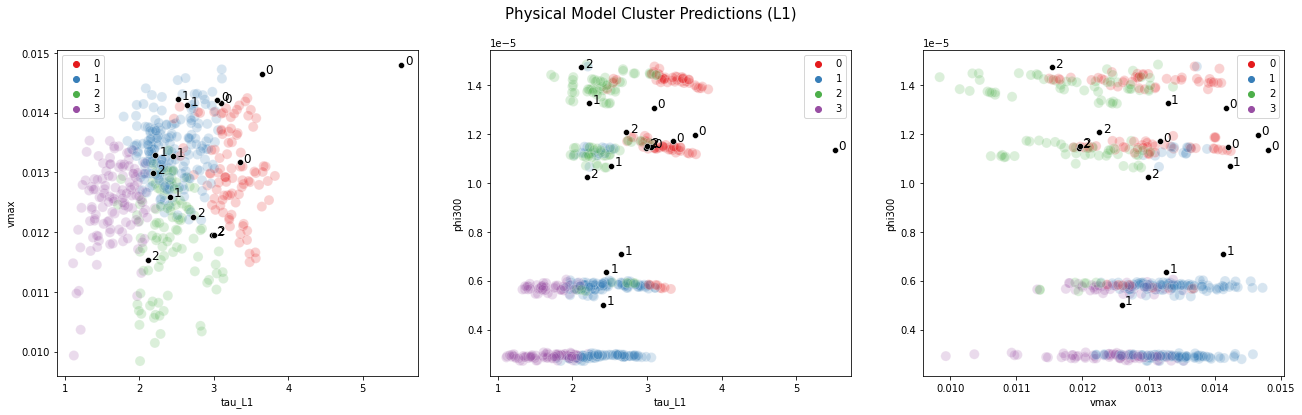

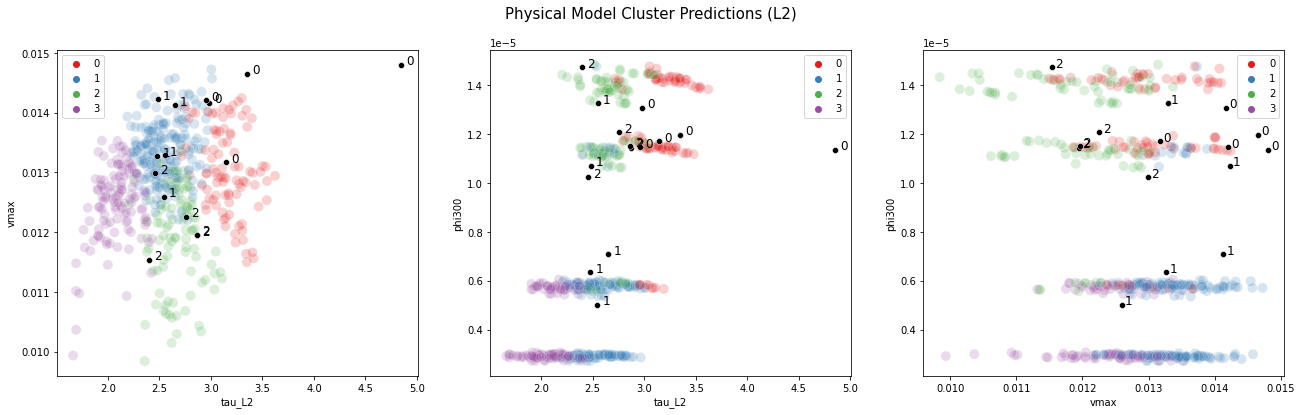

In [ ]:
def plot_predictions(labels, clusters, df_physical, cluster_test_round):
  '''
  plot L1 and L2 physical data predictions

  inputs:
  labels - dataframe of cluster labels for the "clusters" parameter
  clusters - dataframe of supernova simulation gamma ray data for L1 and L2
  df_physical - dataframe of physical model test points
  cluster_test_round - dataframe of cluster predictions for each test point (rounded)
  '''
  # L1 plots
  fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(22,6))
  sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,2], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax1)
  sns.scatterplot(x='tau_L1', y='vmax', data=df_physical, color='black', ax=ax1)
  sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,3], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax2)
  sns.scatterplot(x='tau_L1', y='phi300', data=df_physical, color='black', ax=ax2) #fix - use df_physical for phi300
  sns.scatterplot(clusters.iloc[:,2],clusters.iloc[:,3], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax3)
  sns.scatterplot(x='vmax', y='phi300', data=df_physical, color='black', ax=ax3)

  for i in range(len(df_physical)):
    ax1.text(df_physical["tau_L1"].iloc[i]+.05, df_physical["vmax"].iloc[i], '%s' % (str(int(cluster_test_round['cluster'].iloc[i]))), size=12, zorder=1, color='k')
    ax2.text(df_physical["tau_L1"].iloc[i]+.05, df_physical["phi300"].iloc[i], '%s' % (str(int(cluster_test_round['cluster'].iloc[i]))), size=12, zorder=1, color='k')
    ax3.text(df_physical["vmax"].iloc[i]+.00005, df_physical["phi300"].iloc[i], '%s' % (str(int(cluster_test_round['cluster'].iloc[i]))), size=12, zorder=1, color='k')

  fig.suptitle("Physical Model Cluster Predictions (L1)", fontsize=15) 
  plt.show()

  # L2 plots
  fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(22,6))
  sns.scatterplot(clusters.iloc[:,1],clusters.iloc[:,2], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax1)
  sns.scatterplot(x='tau_L2', y='vmax', data=df_physical, color='black', ax=ax1)
  sns.scatterplot(clusters.iloc[:,1],clusters.iloc[:,3], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax2)
  sns.scatterplot(x='tau_L2', y='phi300', data=df_physical, color='black', ax=ax2)
  sns.scatterplot(clusters.iloc[:,2],clusters.iloc[:,3], hue=labels, palette='Set1', s=100, alpha=0.2, ax=ax3)
  sns.scatterplot(x='vmax', y='phi300', data=df_physical, color='black', ax=ax3)

  for i in range(len(df_physical)):
    ax1.text(df_physical["tau_L2"].iloc[i]+.05, df_physical["vmax"].iloc[i], '%s' % (str(int(cluster_test_round['cluster'].iloc[i]))), size=12, zorder=1, color='k')
    ax2.text(df_physical["tau_L2"].iloc[i]+.05, df_physical["phi300"].iloc[i], '%s' % (str(int(cluster_test_round['cluster'].iloc[i]))), size=12, zorder=1, color='k')
    ax3.text(df_physical["vmax"].iloc[i]+.00005, df_physical["phi300"].iloc[i], '%s' % (str(int(cluster_test_round['cluster'].iloc[i]))), size=12, zorder=1, color='k')

  fig.suptitle("Physical Model Cluster Predictions (L2)", fontsize=15) 
  plt.show()

# plot cluster predictions for physical models, overlaying observable params from simulation data
labels = labels_kmeans.copy()
clusters = clusters_kmeans
plot_predictions(labels, clusters, df_physical, cluster_test_round)

#Mean Shift: Regression Predictions and Testing
To compare between a clustering method resulting in four clusters (KMeans), a clustering method resulting in two clusters, mean-shift, is tested. The dataframe corresponding to mean-shift produced clusters is trained using the random forest regression model. The observable parameters of the physical model test points are then used as inputs for predicting physical parameters, and the cluster predictions are plotted in a similar manner to the KMeans results above.

In [ ]:
# test train split with mean shift cluster data
# combined with simulation data
train, test = train_test_split(df_ms, test_size=0.2, random_state=42, shuffle=True)

# train random forest regressor
rff_model_ms = RandomForestRegressor()
rff_model_ms.fit(train[features], train[target])
train.head()

tau_L1  ...  init_56Ni_dist_flag_w7dt
320  2.052015  ...                         0
329  2.982108  ...                         0
173  2.916139  ...                         0
272  1.468565  ...                         0
491  2.243230  ...                         1

[5 rows x 19 columns]

In [ ]:
# obtain cluster predictions and round
test_ms_df = physical_cluster_predictions(rff_model_ms)
cluster_test_ms_df = test_ms_df[['cluster']]
cluster_test_ms_round = pd.DataFrame(np.round(cluster_test_ms_df['cluster'], decimals = 0))
cluster_test_ms_round.head()

cluster
0      0.0
0      0.0
0      1.0
0      1.0
0      1.0

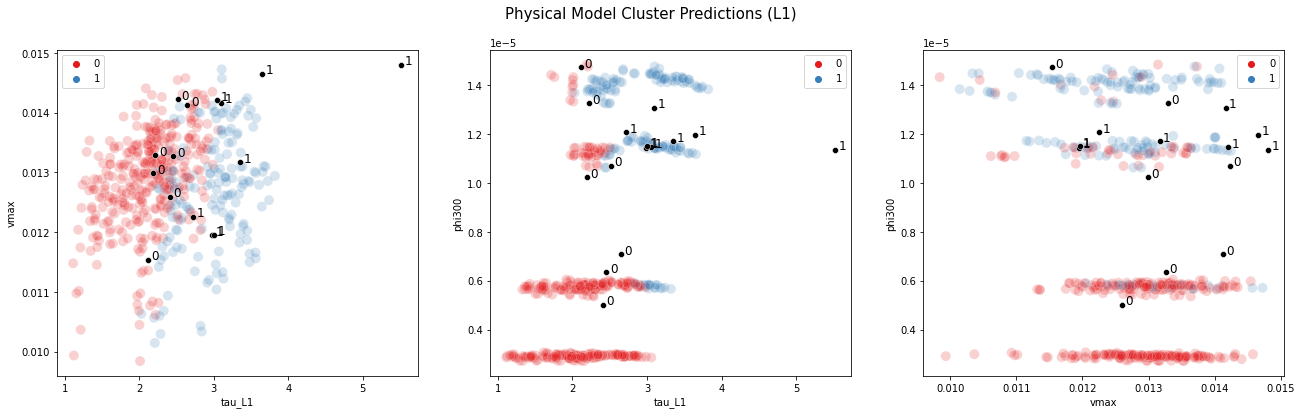

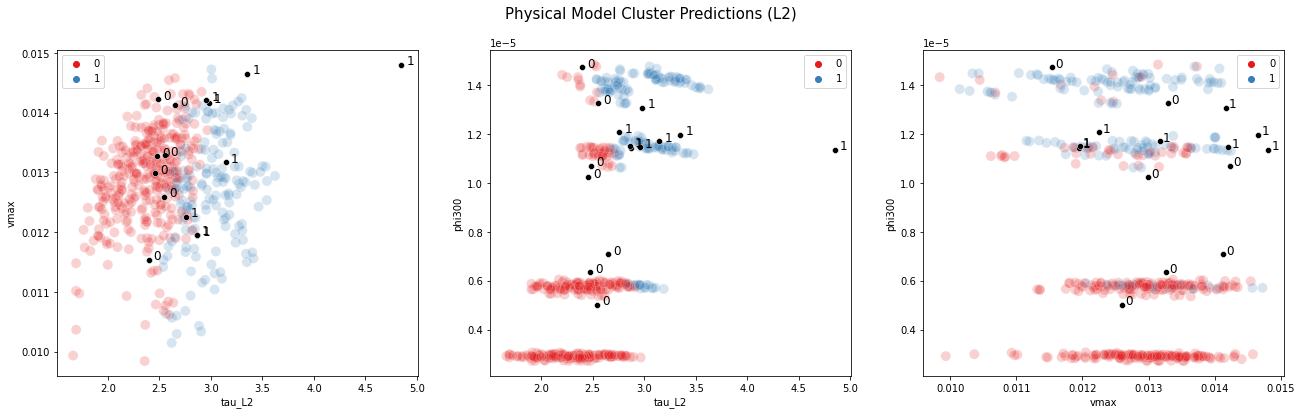

In [ ]:
# plot physical test point predictions
labels = labels_ms.copy()
clusters = clusters_ms
plot_predictions(labels, clusters, df_physical, cluster_test_ms_round)

#References


#### Clustering Algorithms
- https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556
- https://en.wikipedia.org/wiki/Cluster_analysis
- https://www.analytixlabs.co.in/blog/types-of-clustering-algorithms/
- https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68

#### Preprocessing
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

####PCA
- https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html

- https://www.reneshbedre.com/blog/principal-component-analysis.html

- https://www.researchgate.net/post/What_does_negative_factor_loading_imply_in_PCA

- https://www.theanalysisfactor.com/principal-component-analysis-negative-loadings/

####Agglomerative Hierarchical Clustering
- https://www.xlstat.com/en/solutions/features/agglomerative-hierarchical-clustering-ahc

####Mean Shift Clustering
- https://www.geeksforgeeks.org/ml-mean-shift-clustering/
https://spin.atomicobject.com/2015/05/26/mean-shift-clustering/


####Mean Shift Clustering: Kernel Bandwidth
- https://stackoverflow.com/questions/28335070/how-to-choose-appropriate-quantile-value-while-estimating-bandwidth-in-meanshift

- https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/cluster/_mean_shift.py

- https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html

####DBSCAN

- https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

- https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan

- https://stats.stackexchange.com/questions/406587/determining-epsilon-for-dbscan

- https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

####Gaussian Mixture Models

- https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6

- https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

####AIC/BIC

- https://www.methodology.psu.edu/resources/AIC-vs-BIC/

####MAE and RMSE

- https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d

- https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error


####NRMSE
- https://towardsdatascience.com/ways-to-evaluate-regression-models-77a3ff45ba70

# Appendix

##Clustering algorithm sub-categories
- Centroid-based clustering: k-means, k-median, mean-shift
- Hierarchical clustering: Agglomerative, Divisive
- Density-based clustering: DBSCAN
- Distribution-based clustering: gaussian mixture



##Clustering Validation Techniques
- *internal cluster validation*: uses internal information of the clustering process to evaluate the clustering structure without reference to external information. Can also be used for estimating the number of clusters and appropriate clustering algorithm. Examples: silhouette coefficient(average distance between clusters) and Dunn index(minimum separation between clusters divided by maximum intra-cluster diameter -- want to maximize)

  Internal Validation Considerations
  1. Compactness: (or cluster cohesion) Measures how close are the objects within the same cluster. A lower within-cluster variation is an indicator of a good compactness. The different indices for evaluating the compactness of clusters are base on distance measures such as the cluster-wise within average/median distances between observations.
  2. Separation: Measures how well-separated a cluster is from other clusters. The indices used as separation measures include:
    - distances between cluster centers
    - the pairwise minimum distances between objects in different clusters
  3. Connectivity: corresponds to what extent items are placed in the same cluster as their nearest neighbors in the data space. The connectivity has a value between 0 and infinity and should be minimized.

- *external cluster validation*: consists in comparing the results of a cluster analysis to an externally known result (such as externally provided class labels). Measures the extent to which cluster labels match externally supplied class labels -- need to know the "true" cluster number in advance
- *relative cluster validation*: evaluates the clustering structure by varying parameter values for the same algorithm (such as varying the number of clusters k). Generally used for determining the optimal number of clusters

https://www.datanovia.com/en/lessons/cluster-validation-statistics-must-know-methods/

##Nearest Neighbors

"The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice."  

`n_neighbors = (length of data array)*(quantile)`

The KNN Algorithm
1. Load the data
2. Initialize K to your chosen number of neighbors
3. For each example in the data:

      a. Calculate the distance between the query example and the current example from the data.

      b. Add the distance and the index of the example to an ordered collection

4. Sort the ordered collection of distances and indices from smallest to largest (in ascending order) by the distances
5. Pick the first K entries from the sorted collection
6. Get the labels of the selected K entries
7. If regression, return the mean of the K labels
8. If classification, return the mode of the K labels

#Regression Without Clusters

In [ ]:
# Data preparation
df_view_no_clust = df_L2.copy()
df_L1_concat = df_L1[["tau_L1", "tau_uncertainty_L1"]]
df_view_no_clust = pd.concat([df_L1_concat, df_view_no_clust], axis=1, join='inner')
# get dummies - one hot encoding
df_view_no_clust = pd.get_dummies(df_view_no_clust)
df_view_no_clust.head()

tau_L1  ...  init_56Ni_dist_flag_w7dt
0  1.333810  ...                         0
1  1.853153  ...                         0
2  1.682448  ...                         0
3  1.123935  ...                         1
4  1.295746  ...                         0

[5 rows x 18 columns]

In [ ]:
print("REGRESSION WITHOUT CLUSTERS \n")
target_no_clust = list(df_view_no_clust.columns)
target_no_clust.remove("tau_L1")
target_no_clust.remove("tau_L2")
target_no_clust.remove("vmax")
target_no_clust.remove("phi300")
features = ["tau_L1", "tau_L2", "vmax", "phi300"]

kfold_kmeans_results_no_clust = repeated_kfold_regression(features, target_no_clust, df_view_no_clust)

REGRESSION WITHOUT CLUSTERS 

RANDOM FOREST REGRESSION
MAE: 0.205 (0.005)
RMSE: 0.338 (0.008)
NRMSE: 0.841 (0.019)
DECISION TREE REGRESSION
MAE: 0.199 (0.011)
RMSE: 0.444 (0.012)
NRMSE: 1.105 (0.030)
LINEAR REGRESSION
MAE: 0.238 (0.003)
RMSE: 0.337 (0.004)
NRMSE: 0.838 (0.011)
K NEAREST NEIGHBORS REGRESSION
MAE: 0.227 (0.005)
RMSE: 0.364 (0.005)
NRMSE: 0.905 (0.013)


In [ ]:
for model in kfold_kmeans_results:
  print(model)
  print('MAE CLUSTER: %.3f (%.3f)' % (kfold_kmeans_results[model][0], kfold_kmeans_results[model][1]), 'MAE NO CLUSTER: %.3f (%.3f)' % (kfold_kmeans_results_no_clust[model][0], kfold_kmeans_results_no_clust[model][1]))
  print('RMSE CLUSTER: %.3f (%.3f)' % (kfold_kmeans_results[model][2], kfold_kmeans_results[model][3]), 'RMSE NO CLUSTER: %.3f (%.3f)' % (kfold_kmeans_results_no_clust[model][2], kfold_kmeans_results_no_clust[model][3]))

RANDOM FOREST REGRESSION
MAE CLUSTER: 0.250 (0.006) MAE NO CLUSTER: 0.205 (0.005)
RMSE CLUSTER: 0.377 (0.008) RMSE NO CLUSTER: 0.338 (0.008)
DECISION TREE REGRESSION
MAE CLUSTER: 0.240 (0.013) MAE NO CLUSTER: 0.199 (0.011)
RMSE CLUSTER: 0.499 (0.014) RMSE NO CLUSTER: 0.444 (0.012)
LINEAR REGRESSION
MAE CLUSTER: 0.316 (0.004) MAE NO CLUSTER: 0.238 (0.003)
RMSE CLUSTER: 0.397 (0.005) RMSE NO CLUSTER: 0.337 (0.004)
K NEAREST NEIGHBORS REGRESSION
MAE CLUSTER: 0.290 (0.007) MAE NO CLUSTER: 0.227 (0.005)
RMSE CLUSTER: 0.424 (0.007) RMSE NO CLUSTER: 0.364 (0.005)


##Investigating Incorporating Parameter Uncertainty in Clustering
**Potential Resources**

**Fuzzy Clustering** - each data point can belong to more than one cluster:

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.85.8907&rep=rep1&type=pdf

**COBWEB Conceptual Clustering** - generates a concept
descriptor for each cluster. The clusters COBWEB creates are formed into a tree.
The leaves of the tree represent every individual
concept; the root node represents the whole dataset;
and the branches represent the hierarchical clusters
within the dataset. The total number of clusters can be
up to by the size of the dataset. 

https://www.stat.purdue.edu/~xbw/research/ICTAI2007.pdf

http://www.ijitjournal.org/volume-3/issue-3/IJIT-V3I3P7.pdf


**Weighted-Data Gaussian mixture
model (WD-GMM)**

https://arxiv.org/pdf/1509.01509.pdf

https://link.springer.com/article/10.1007%2Fs10596-019-9823-3

**MCLUST-ME** "an extension to Gaussian mixture modeling that properly accounts for measurement or estimation errors in the special case when the error distributions are either known or can be estimated, as well as introduces the clustering algorithm built upon it"

https://pubmed.ncbi.nlm.nih.gov/32050700/

**Gaussian Mixture Model Bootstrapping**

https://arxiv.org/pdf/1510.00551.pdf

https://link.springer.com/article/10.1007/s00180-019-00897-9

**ELKI Framework (in Java)**

http://www.vldb.org/pvldb/vol8/p1976-schubert.pdf
https://dl.acm.org/doi/10.14778/2824032.2824115